In [2]:
### Andrew Dant & Alicia Hernandez
### AI 570
### Professor Wang
### Chest X-Ray Project

#Libraries and stuff
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

#Upload the CSV file
path = r"C:\Users\andrew.dant\Downloads\archive"
os.chdir(path)
patients = pd.read_csv("Data_Entry_2017.csv")

#Data Exploration
print(patients.head())
print(patients.columns)
print(patients.describe())
print(patients.shape)  #(112120, 12)
print(patients.dtypes)     #object, int64, float64


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [3]:
print(patients['Patient Gender'].unique())
# encode patient gender as zero or one
patients['Patient Gender'] = patients['Patient Gender'].map({'M': 0, 'F': 1})

['M' 'F']


In [4]:
print(patients['View Position'].unique())
# encode patient gender as zero or one
patients['View Position'] = patients['View Position'].map({'PA': 0, 'AP': 1})

['PA' 'AP']


In [5]:
# empty/fake column caused by a trailing comma in the CSV file
columns_to_drop = ['Unnamed: 11']
all_patient_data_columns = patients
patients = patients.drop(columns=columns_to_drop)

In [6]:

# Clean column names
patients.columns = (
    patients.columns
    .str.lower()               # Convert to lowercase
    .str.replace(' ', '_')     # Replace spaces with underscores
    .str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters
    .str.strip()               # Strip whitespace
)

print("Cleaned column names:")
print(patients.columns)


Cleaned column names:
Index(['image_index', 'finding_labels', 'followup_', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'originalimagewidth',
       'height', 'originalimagepixelspacingx', 'y'],
      dtype='object')


In [7]:
feature_columns = ['patient_age', 'patient_gender', 'view_position']
print(patients[feature_columns].head())

   patient_age  patient_gender  view_position
0           58               0              0
1           58               0              0
2           58               0              0
3           81               0              0
4           81               1              0


In [8]:
# determine the set of unique interests
finding_set = set()
for finding_list in patients['finding_labels'].tolist():
    for finding in finding_list.split('|'):
        finding_set.add(finding)
        
print(f'Unique diagnoses in "finding_labels": {sorted(finding_set)}')

label_columns = [finding for finding in finding_set]

# build the columns and rows of the dummy variables
dummy_finding_variables = []
for finding_list in patients['finding_labels'].tolist():
    dummy_finding_variables.append([1 if finding in finding_list.split('|') else 0 for finding in finding_set])

dummy_finding_variables = pd.DataFrame(dummy_finding_variables, columns=label_columns)

# replace the old finding labels column with the dummy variables
patients.drop('finding_labels', axis=1, inplace=True)
patients = patients.join(dummy_finding_variables)
patients.dtypes

print(patients.iloc[:, -15:])


Unique diagnoses in "finding_labels": ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
        Pneumonia  Cardiomegaly  Hernia  Effusion  Pneumothorax  Emphysema  \
0               0             1       0         0             0          0   
1               0             1       0         0             0          1   
2               0             1       0         1             0          0   
3               0             0       0         0             0          0   
4               0             0       1         0             0          0   
...           ...           ...     ...       ...           ...        ...   
112115          1             0       0         0             0          0   
112116          0             0       0         0             0          0   
112117          0             0       0         0       

In [9]:


#Remove NA's
patients.isnull()   #Find missing values in data set
patients = patients.dropna()    #Drop Null values and update df

patients.describe()


,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,Pneumonia,...,Emphysema,Infiltration,No Finding,Atelectasis,Edema,Pleural_Thickening,Fibrosis,Nodule,Mass,Consolidation
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,0.435070,0.399661,2646.078844,2486.438842,0.155649,0.155649,0.012763,...,0.022440,0.177435,0.538361,0.103095,0.020540,0.030191,0.015037,0.056466,0.051570,0.041625
std,15.406320,8403.876972,16.839923,0.495768,0.489831,341.246429,401.268227,0.016174,0.016174,0.112251,...,0.148111,0.382038,0.498529,0.304084,0.141841,0.171113,0.121702,0.230821,0.221158,0.199732
min,0.000000,1.000000,1.000000,0.000000,0.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,0.000000,0.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,0.000000,0.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,1.000000,1.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,1.000000,1.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:

#Find duplicate values
patients.duplicated().sum()     #No duplicates


0

In [11]:

patients[feature_columns]


,patient_age,patient_gender,view_position
0,58,0,0
1,58,0,0
2,58,0,0
3,81,0,0
4,81,1,0
...,...,...,...
112115,39,0,0
112116,29,0,0
112117,42,1,0
112118,30,1,0


In [12]:
#Correlation
# columns with a numeric datatype, other than the new dummy variables for encoding classes
numeric_features_patients = patients[feature_columns].select_dtypes(include=[np.number])
if not numeric_features_patients.empty:
    print(numeric_features_patients.corr())
else:
    print("No numeric columns to compute correlation.")     #No numeric columns to compute correlation.


                patient_age  patient_gender  view_position
patient_age        1.000000       -0.019823      -0.032861
patient_gender    -0.019823        1.000000      -0.032411
view_position     -0.032861       -0.032411       1.000000


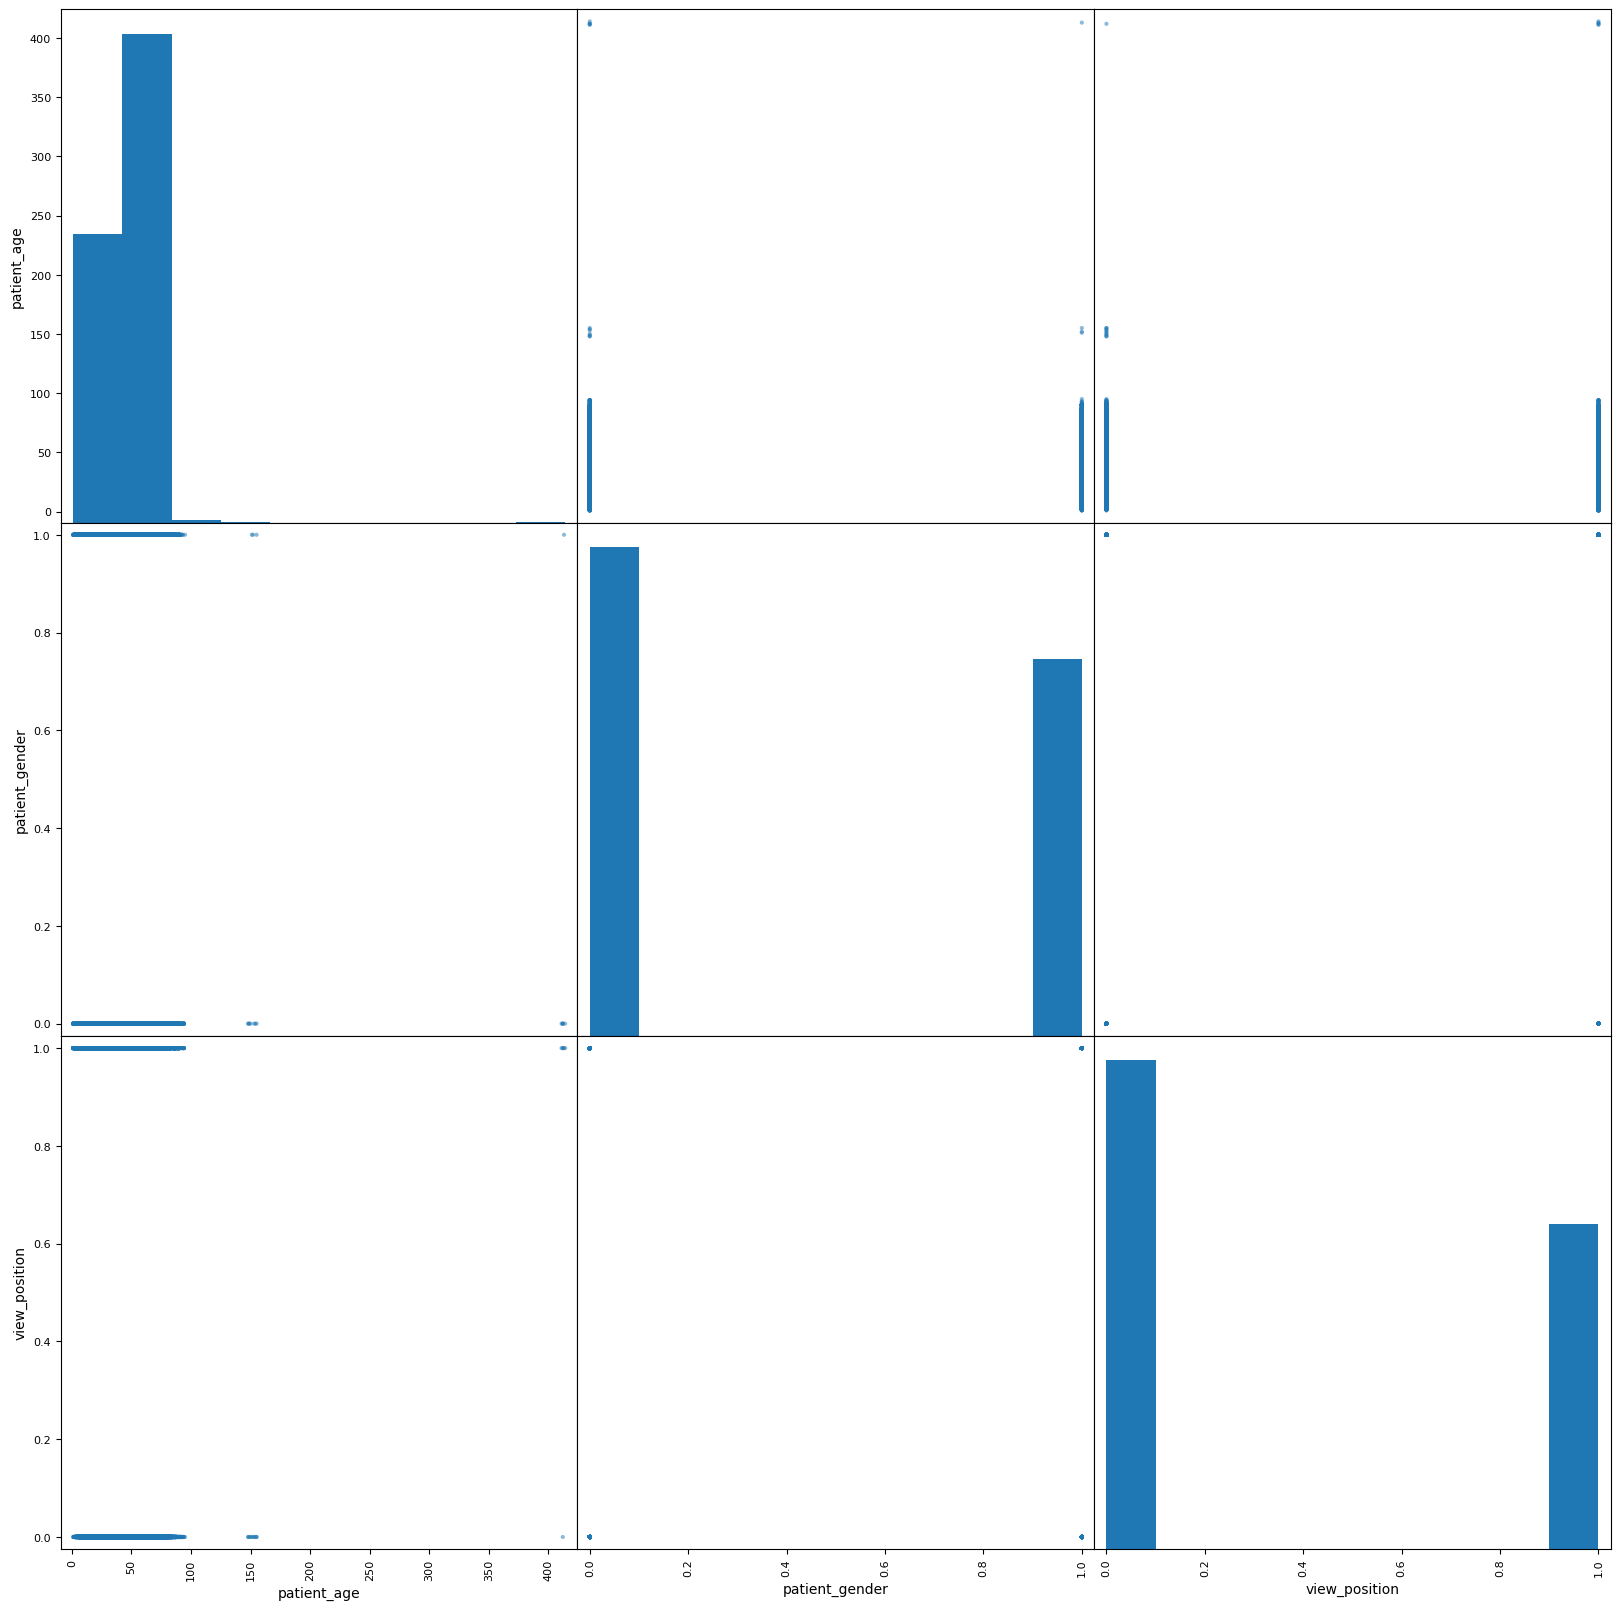

In [13]:

#Scatterplot matrix
if not numeric_features_patients.empty and not numeric_features_patients.isnull().all(axis=0).any():
    pd.plotting.scatter_matrix(numeric_features_patients, figsize=(20, 20))
    plt.show()
else:
    print("No valid numeric data available for scatter matrix.")    #No valid numeric data available for scatter matrix.


In [14]:
patients['patient_age']

0         58
1         58
2         58
3         81
4         81
          ..
112115    39
112116    29
112117    42
112118    30
112119    27
Name: patient_age, Length: 112120, dtype: int64

In [15]:
#Scale the data
scaler = MinMaxScaler()
patients[numeric_features_patients.columns] = scaler.fit_transform(patients[numeric_features_patients.columns])

In [16]:
patients.head()

,image_index,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,...,Emphysema,Infiltration,No Finding,Atelectasis,Edema,Pleural_Thickening,Fibrosis,Nodule,Mass,Consolidation
0,00000001_000.png,0,1,0.138015,0.0,0.0,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,0.138015,0.0,0.0,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,0.138015,0.0,0.0,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,0.193705,0.0,0.0,2500,2048,0.171,0.171,...,0,0,1,0,0,0,0,0,0,0
4,00000003_000.png,0,3,0.193705,1.0,0.0,2582,2991,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0


In [17]:
file_names = []
for root, dirs, files in os.walk(path):
    file_names.extend([filename for filename in files if '.png' in filename])
    
print(len(file_names))  # the number of image files should match the number of rows in patients

112120


In [18]:

#begin merging the dataset 

# Filter the DataFrame for existing images
patients_with_images = patients[patients['image_index'].isin(file_names)]

print(patients_with_images.describe())


           followup_     patient_id    patient_age  patient_gender  \
count  112120.000000  112120.000000  112120.000000   112120.000000   
mean        8.573751   14346.381743       0.111142        0.435070   
std        15.406320    8403.876972       0.040775        0.495768   
min         0.000000       1.000000       0.000000        0.000000   
25%         0.000000    7310.750000       0.082324        0.000000   
50%         3.000000   13993.000000       0.116223        0.000000   
75%        10.000000   20673.000000       0.140436        1.000000   
max       183.000000   30805.000000       1.000000        1.000000   

       view_position  originalimagewidth         height  \
count  112120.000000       112120.000000  112120.000000   
mean        0.399661         2646.078844    2486.438842   
std         0.489831          341.246429     401.268227   
min         0.000000         1143.000000     966.000000   
25%         0.000000         2500.000000    2048.000000   
50%         0.0

In [19]:
# Loads images from all subdirectories
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"C:\Users\andrew.dant\Downloads\archive\images_001",
    labels=None,
    image_size=(224, 224),  # all images are resized to this size. Should match model's expectations
    batch_size=None
)


Found 4999 files belonging to 1 classes.


In [20]:

# Map image filenames to row data in patients. Reindex patients to match image order (this will throw an error if there are any image files without an associated row)
patients = patients.set_index("image_index")
patients = patients.loc[[path.split("\\")[-1] for path in image_dataset.file_paths]]
dataset_length = len(patients)


In [21]:

# Convert feature and label data to TensorFlow datasets
features_dataset = tf.data.Dataset.from_tensor_slices(patients[feature_columns].values)
labels_dataset = tf.data.Dataset.from_tensor_slices(patients[label_columns].values)

combined_dataset = tf.data.Dataset.zip(((image_dataset, features_dataset), labels_dataset))

In [22]:
# randomize the order of the dataset so we are not splitting the sets based on which folder the images are in
combined_dataset = combined_dataset.shuffle(buffer_size=combined_dataset.cardinality(), seed=1)

# Split into train and test sets (may add validation in the future)
train_size = int(0.7 * dataset_length)
test_size = dataset_length - train_size

train_dataset = combined_dataset.take(train_size)
test_dataset = combined_dataset.skip(test_size)

batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [23]:
from keras.applications.resnet import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.utils import plot_model
from keras.optimizers import Adam

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
image_input = base_model.input

# Freeze the layers of ResNet50 so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# TODO does it make sense to use this architecture as well as the global average pooling layer for our problem?

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)  # Flatten the output for merging with the numerical path

# Define the numerical input path
patient_input = tf.keras.Input(shape=(len(feature_columns),), name="patient_input")
y = Dense(8, activation="relu")(patient_input)

# Concatenate the outputs from the two paths
combined = Concatenate()([x, y])

# Add additional dense layers for combined processing
z = Dense(128, activation="relu")(combined)
z = Dense(64, activation="relu")(z)

# Final output layer for multi-label classification
num_labels = len(label_columns)
output = Dense(num_labels, activation="sigmoid")(z)  # Sigmoid for multi-label binary classification

# Define the model with both inputs and the single output
model = tf.keras.Model(inputs=[image_input, patient_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Display model architecture
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
# plot_model(model, to_file='xray_model.png')

In [29]:
import os

# Path to save/load model weights
weights_path = "model_weights.h5"

if os.path.exists(weights_path):
    print("Loading saved model weights...")
    model.load_weights(weights_path)
else:
    print("No saved weights found. Training the model...")

    history = model.fit(
        train_dataset,
        epochs=5
    )

    # Save the trained weights
    print("Saving model weights...")
    model.save_weights(weights_path)


Loading saved model weights...


In [30]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions on the test set
predictions = model.predict(test_dataset)


110/110 [==============================] - 88s 750ms/step - loss: 0.2147 - accuracy: 0.5550
Test Loss: 0.2147
Test Accuracy: 0.5550
110/110 [==============================] - 90s 751ms/step


In [42]:

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
binary_predictions = (predictions > 0.5).astype(int)

# Generate a classification report
print(classification_report(y_true, binary_predictions))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00       136
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00       359
           4       0.00      0.00      0.00       149
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00       582
           7       0.54      0.92      0.68      1903
           8       0.00      0.00      0.00       330
           9       0.00      0.00      0.00        66
          10       0.00      0.00      0.00       110
          11       0.00      0.00      0.00       123
          12       0.00      0.00      0.00       145
          13       0.00      0.00      0.00       112
          14       0.00      0.00      0.00       147

   micro avg       0.54      0.41      0.46      4314
   macro avg       0.04      0.06      0.05      4314
weighted avg       0.24   

c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


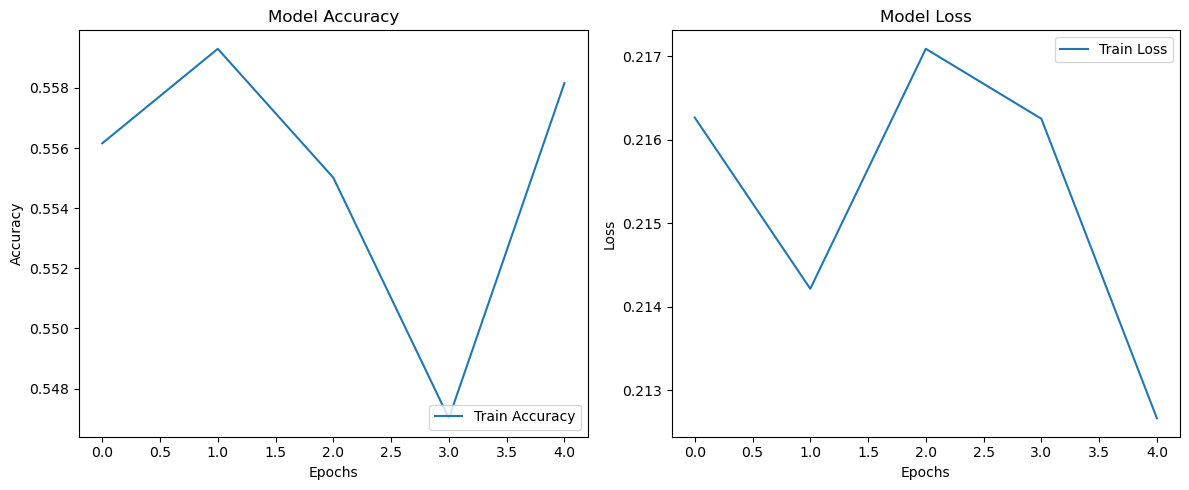

In [43]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()